In [35]:
import os
import shutil
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import Xception, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Prepararion

You can use the Fruit dataset from https://www.kaggle.com/datasets/shivamardeshna/fruits-dataset or choose any other dataset to train.

Be careful as each model has a **different structure**, please change the way you prepare the data if you use a different dataset.

Feel free to explore!

In [3]:
# Paths to the target directories
base_dir = 'split-dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Create the target directories if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [4]:
# Counts the number of images in each class directory.
def count_images_in_directory(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len(os.listdir(class_path))
    return class_counts

# Counts the images and plots the class distribution for a given directory.
def plot_class_distribution(directory, title):
    class_counts = count_images_in_directory(directory)
    print(f"{title} class distribution:", class_counts)


Training Set Class Distribution class distribution: {'freshapples': 460, 'freshbanana': 497, 'freshoranges': 543, 'rottenapples': 477, 'rottenbanana': 456, 'rottenoranges': 458}


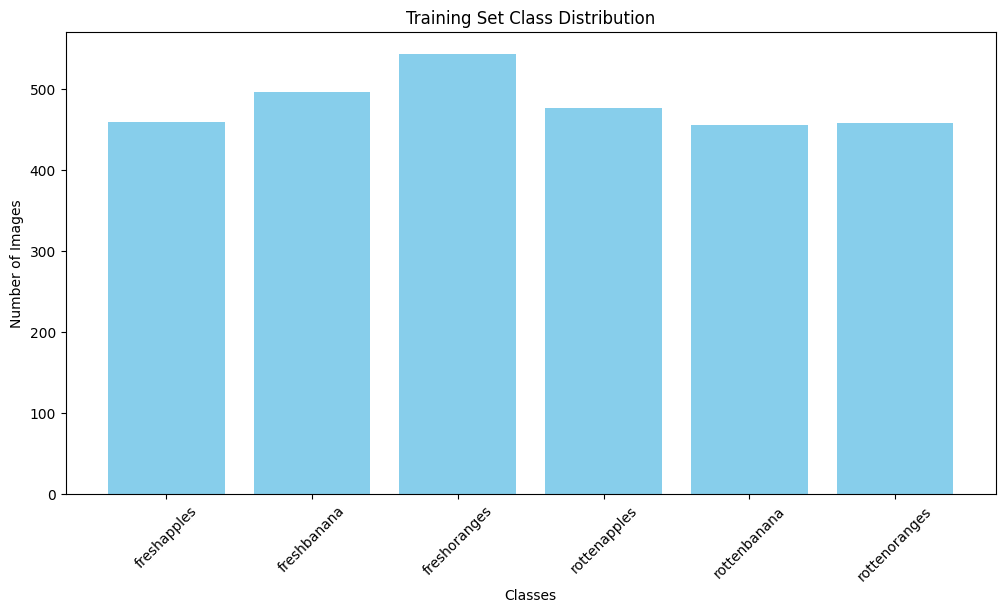

In [5]:
# Counts the images and plots the class distribution for a given directory.
def plot_class_distribution(directory, title):
    class_counts = count_images_in_directory(directory)
    print(f"{title} class distribution:", class_counts)
    
    classes = list(class_counts.keys())
    values = list(class_counts.values())
        
    plt.figure(figsize=(12, 6))
    plt.bar(classes, values, color='skyblue')
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()


# Plot class distributions
plot_class_distribution(train_dir, 'Training Set Class Distribution')

In [6]:

"""
    Generates a DataFrame with image file paths and labels from a directory.

    Args:
        directory (str): Root directory to search.

    Returns:
        pd.DataFrame: Contains 'file_path' and 'label' columns, 
        where 'label' is 0 if 'fresh' is in the directory path, otherwise 1.
"""
def create_dataframe(directory):
    data = []
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                file_path = os.path.join(subdir, file)
                label = 0 if 'fresh' in subdir.lower() else 1
                data.append([file_path, label])
    return pd.DataFrame(data, columns=['file_path', 'label'])

train_df = create_dataframe(train_dir)
validation_df = create_dataframe(validation_dir)
test_df = create_dataframe(test_dir)

In [7]:
train_df

file_path  label
0     split-dataset\train\freshapples\rotated_by_15_...      0
1     split-dataset\train\freshapples\rotated_by_15_...      0
2     split-dataset\train\freshapples\rotated_by_15_...      0
3     split-dataset\train\freshapples\rotated_by_15_...      0
4     split-dataset\train\freshapples\rotated_by_15_...      0
...                                                 ...    ...
2886  split-dataset\train\rottenoranges\vertical_fli...      1
2887  split-dataset\train\rottenoranges\vertical_fli...      1
2888  split-dataset\train\rottenoranges\vertical_fli...      1
2889  split-dataset\train\rottenoranges\vertical_fli...      1
2890  split-dataset\train\rottenoranges\vertical_fli...      1

[2891 rows x 2 columns]

# Data augmentation

In [27]:

# Path to the directory containing images of the "freshbanana" class
fresh_banana_dir = os.path.join(train_dir, 'freshbanana')

# Data Augmentation for the training set
# Create an ImageDataGenerator for data augmentation
train_datagen_augmented = ImageDataGenerator(
    # preprocessing_function=tf.keras.applications.xception.preprocess_input,
    rescale=1./255,
    # rotation_range=40,
    # your data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    # horizontal_flip=True,
    fill_mode='nearest'
)

# Rescale without augmentation for visualization
no_aug = ImageDataGenerator(rescale=1./255)


# Get all images from the "fresh_banana_dir" directory
fresh_banana_images = os.listdir(fresh_banana_dir)
train_counts = count_images_in_directory(train_dir)
# Calculate the number of images needed to balance with the mean of the other classes using NumPy
class_counts = np.array(list(train_counts.values()))
mean_images = int(np.mean(class_counts))
current_fresh_banana_count = len(fresh_banana_images)
needed_fresh_banana_images = mean_images - current_fresh_banana_count

print(f"Need to generate {needed_fresh_banana_images} more images for 'freshbanana' class.")

i = 0
for img_name in fresh_banana_images:
    img_path = os.path.join(fresh_banana_dir, img_name)
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape) # Add batch size dimension

    #Generate augmented images and save them to the "fresh_banana" directory
    for batch in train_datagen_augmented.flow(x, batch_size=1, save_to_dir=fresh_banana_dir, save_prefix='aug', save_format='jpeg'):
        i+=1
        if i >= needed_fresh_banana_images:
            break
    if i >= needed_fresh_banana_images:
        break

print(f"Generated {needed_fresh_banana_images} additional images for 'trash' class.")

"""
    Creates batches of images and labels from a DataFrame.

    This function uses an ImageDataGenerator to load and process images from a DataFrame.
    It prepares the images and labels for training or testing a model.

    Args:
        datagen (ImageDataGenerator): The tool that processes and augments the images.
        dataframe (pd.DataFrame): The table containing image file paths and labels.
        x_col (str): Column name in the table with the image file paths.
        y_col (str): Column name in the table with the labels.
        batch_size (int): Number of images to return in each batch. Default is 32.
        target_size (tuple): The size to resize all images to. Default is (224, 224).
        shuffle (bool): Whether to mix up the images randomly. Default is True.

    Returns:
        DirectoryIterator: An object that gives back batches of images and labels.
"""
def dataframe_flow_from_directory(datagen, dataframe, x_col='file_path', y_col='label', batch_size=32, target_size=(224, 224), shuffle=True):
    return datagen.flow_from_dataframe(
        dataframe,
        x_col=x_col,
        y_col=y_col,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='raw',  # Outputs labels as raw numbers
        shuffle=shuffle
    )

# Create generator without augmentation for visualization
train_generator_no_aug = dataframe_flow_from_directory(no_aug, train_df, shuffle=True)

Need to generate -16 more images for 'freshbanana' class.
Generated -16 additional images for 'trash' class.
Found 2891 validated image filenames.


Training Set Class Distribution After Augmentation class distribution: {'freshapples': 460, 'freshbanana': 499, 'freshoranges': 543, 'rottenapples': 477, 'rottenbanana': 456, 'rottenoranges': 458}


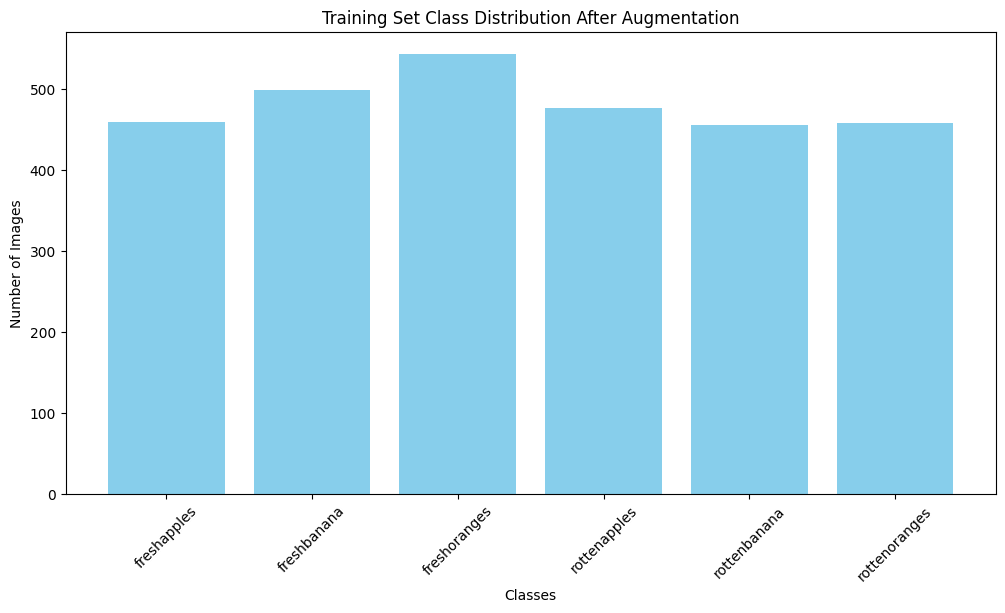

In [28]:
# Show image before and after applying data augmentation
plot_class_distribution(train_dir, 'Training Set Class Distribution After Augmentation')

['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']


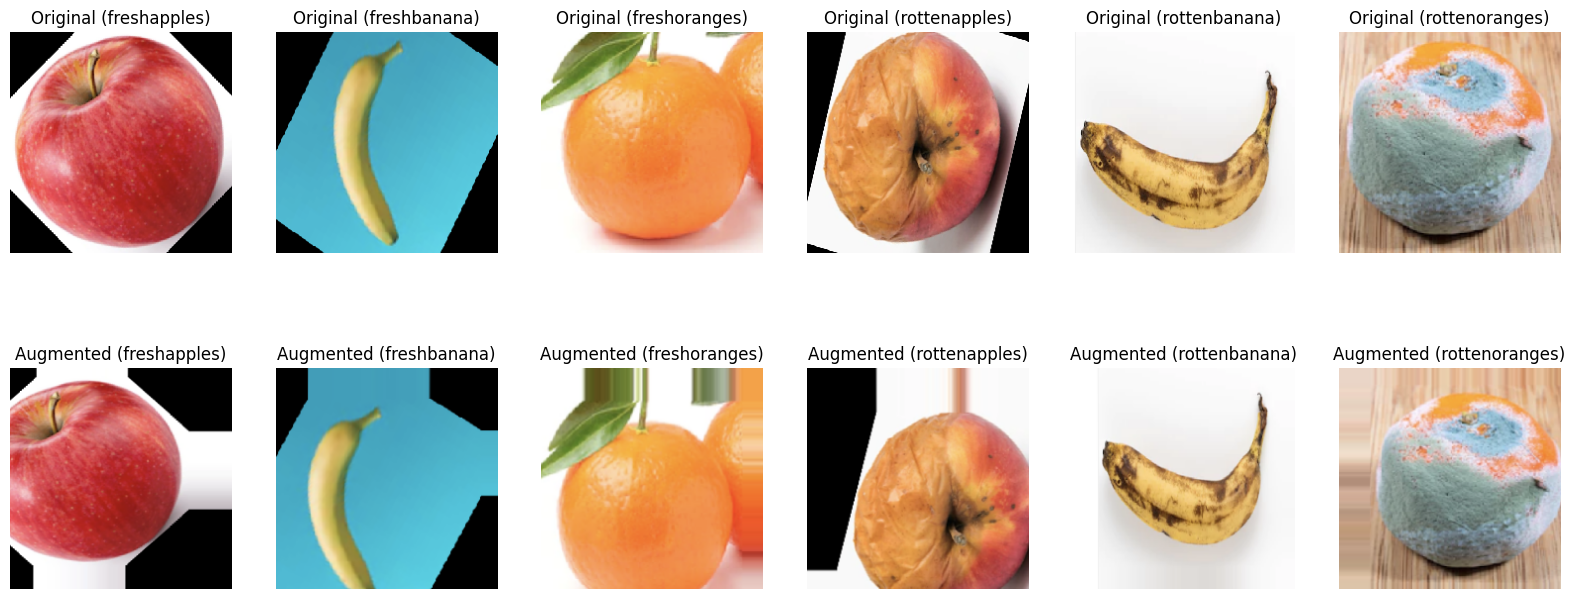

In [29]:
# Data Augmentation Setup in train datasets
datagen = ImageDataGenerator(
    # preprocessing_function=tf.keras.applications.xception.preprocess_input,
    rescale=1./255,
    # rotation_range=40,
    # your data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    # horizontal_flip=True,
    fill_mode='nearest'
)

# Get all subdirectories (classes) in the training set directory
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
print(class_dirs)

# Set up the plot with 2 rows and as many columns as there are classes (len(class_dirs))
fig, axes = plt.subplots(2, len(class_dirs), figsize=(20, 8))

# Loop through each class directory
for i, class_dir in enumerate(class_dirs):
    class_path = os.path.join(train_dir, class_dir)
    sample_images = os.listdir(class_path)
    
    if len(sample_images) == 0:
        continue
    
    # Select and process random image from the class directory
    img_name = random.choice(sample_images)
    img_path = os.path.join(class_path, img_name)
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)  # Add batch size dimension
    
    # Display the original image in the first row
    axes[0, i].imshow(img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Original ({class_dir})')
    
    # Display the augmented and sharpened image in the second row
    for batch in datagen.flow(x, batch_size=1):
        augmented_img = batch[0]
        axes[1, i].imshow(augmented_img)
        axes[1, i].axis('off')
        axes[1, i].set_title(f'Augmented ({class_dir})')
        break  # Only take one augmented sample per original image

plt.show()


# # Function to plot images
# def plot_images(images_arr, title):
#     fig, axes = plt.subplots(1, 5, figsize=(20, 5))
#     axes = axes.flatten()
#     for img, ax in zip(images_arr, axes):
#         ax.imshow(img)
#         ax.axis('off')
#     plt.tight_layout()
#     plt.suptitle(title)
#     plt.show()


# # Get a batch of images from the train generator without augmentation
# sample_images, _ = next(train_generator_no_aug)
# plot_images(sample_images[:5], title="Original Images")

# # Apply Data Augmentation
# augmented_images = [train_datagen_augmented.random_transform(img) for img in sample_images[:5]]
# plot_images(augmented_images, title="Augmented Images")

In [30]:
# Oject is created to preprocess images in the validation and test datasets
# test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.xception.preprocess_input)

# Create data generators using the DataFrame
train_generator = dataframe_flow_from_directory(
  datagen,
  train_df,
  x_col='file_path',
  y_col='label',
  batch_size=32,
  target_size=(224, 224),
  shuffle=True,
) #your input

validation_generator = dataframe_flow_from_directory(
  test_datagen,
  validation_df,
  x_col='file_path',
  y_col='label',
  batch_size=32,
  target_size=(224, 224),
  shuffle=False,
) #your input

test_generator = dataframe_flow_from_directory(
  test_datagen,
  test_df,
  x_col='file_path',
  y_col='label',
  batch_size=32,
  target_size=(224, 224),
  shuffle=False,
) #your input

Found 2891 validated image filenames.
Found 2442 validated image filenames.
Found 88 validated image filenames.


# Train model

In [ ]:
custom_model = Sequential([
  Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(224, 224, 3)),
  MaxPooling2D((2, 2), strides=2),
  Conv2D(64, (3,3), padding='same', activation='relu'),
  MaxPooling2D((2, 2), strides=2),
  Conv2D(128, (3,3), padding='same', activation='relu'),
  MaxPooling2D((2, 2), strides=2),
  Flatten(),
  Dense(256, activation='relu'),
  Dense(1,  activation='sigmoid')
])

# custom_model.summary())
# custom_model.input_shape)

filepath="customized_fruit_classification.keras"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]

In [ ]:
# Start compile and train custom_model
custom_model.compile(optimizer = Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
custom_history = custom_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks=callbacks_list
)

In [38]:
# Use pre-trained model and build the model
# Xception is widely used for image classification tasks
base_model = InceptionV3(weights='./pretrained_models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the pre-trained model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x) # output to a value between 0 and 1, suitable for binary classification tasks

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False
    
# Create the final model    
model = Model(inputs=base_model.input, outputs=predictions)
# model = Sequential([
#     base_model,
#     GlobalAveragePooling2D(),
#     Dense(128, activation='relu'),
#     Dropout(0.2),
#     Dense(1, activation='sigmoid')  # Single output neuron for binary classification
# ])

filepath="pretrained_fruit_classification.keras"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]


# base_model.summary()
# base_model.input_shape

In [45]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Start compile and train pre-trained model
model.compile(optimizer=Adam(learning_rate=1e-4), loss= 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs= 25,
    # validation_data=validation_generator,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks_list
)

model.save('pretrained_fruit_classification.keras')

Epoch 1/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.9768 - loss: 0.0674
Epoch 1: val_accuracy did not improve from 1.00000
90/90 ━━━━━━━━━━━━━━━━━━━━ 89s 913ms/step - accuracy: 0.9768 - loss: 0.0674 - val_accuracy: 0.9757 - val_loss: 0.0640
Epoch 2/25
 1/90 ━━━━━━━━━━━━━━━━━━━━ 34s 386ms/step - accuracy: 0.9375 - loss: 0.0894
Epoch 2: val_accuracy did not improve from 1.00000
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9375 - loss: 0.0894 - val_accuracy: 1.0000 - val_loss: 2.6096e-04
Epoch 3/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.9805 - loss: 0.0548
Epoch 3: val_accuracy did not improve from 1.00000
90/90 ━━━━━━━━━━━━━━━━━━━━ 80s 872ms/step - accuracy: 0.9804 - loss: 0.0549 - val_accuracy: 0.9778 - val_loss: 0.0621
Epoch 4/25
 1/90 ━━━━━━━━━━━━━━━━━━━━ 33s 380ms/step - accuracy: 0.9688 - loss: 0.0737
Epoch 4: val_accuracy did not improve from 1.00000
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9688 - loss: 0.0737 - val_accuracy: 1.0000

# Evaluate model

In [46]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {accuracy * 100:2f} % - Test loss: {loss:4f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7876 - loss: 0.6438
Test accuracy: 84.090906 % - Test loss: 0.468431


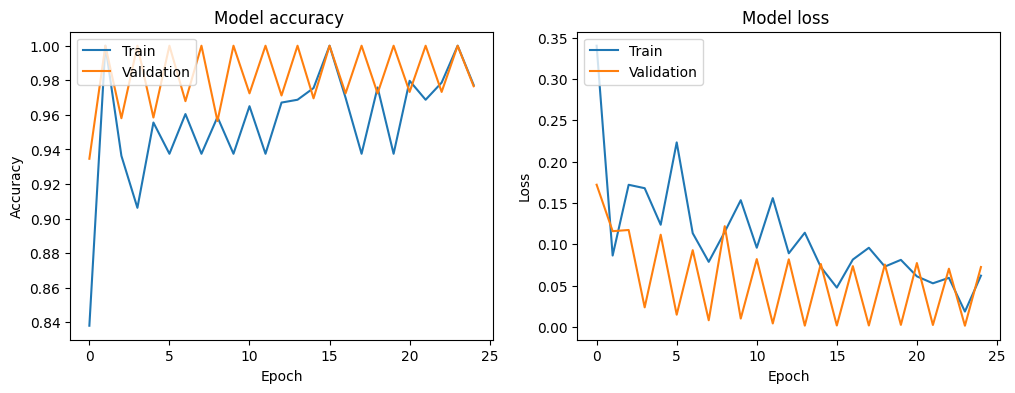

In [42]:
def plot_training_history(history, title_suffix=""):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy {title_suffix}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss {title_suffix}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
plot_training_history(history)

Try to write function to test with 10 random images from test dataset. Show the image, predicted output and actual output!

In [43]:
# Function to load and preprocess images
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image /= 255.0  # Rescale the image
    return image

# Select 10 random images from the test set
# test_image_paths = []
# for class_dir in os.listdir(test_dir):
#     class_path = os.path.join(test_dir, class_dir)
#     images = os.listdir(class_path)
#     random_images = random.sample(images, min(10, len(images)))
#     for img in random_images:
#         test_image_paths.append(os.path.join(class_path, img))

# random.shuffle(test_image_paths)
# test_image_paths = test_image_paths[:10]

# # Load and preprocess the images
# test_images = np.vstack([load_and_preprocess_image(img_path) for img_path in test_image_paths])

# # Make predictions
# predictions = model.predict(test_images)
# predicted_classes = np.round(predictions).astype(int)

# # Get true class names
# true_classes = [path.split('\\')[-2] for path in test_image_paths]
# true_class_indices = [test_generator.class_indices[cls] for cls in true_classes]

# # Convert class_indices to a list of class names
# class_names = list(test_generator.class_indices.keys())

# # Plot the images with predicted and true labels
# plt.figure(figsize=(20, 10))
# for i in range(10):
#     plt.subplot(2, 5, i+1)
#     img = load_img(test_image_paths[i], target_size=(224, 224))
#     plt.imshow(img)
#     plt.axis('off')
#     plt.title(f"True: {true_classes[i]}, Pred: {class_names[predicted_classes[i]]}")
# plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


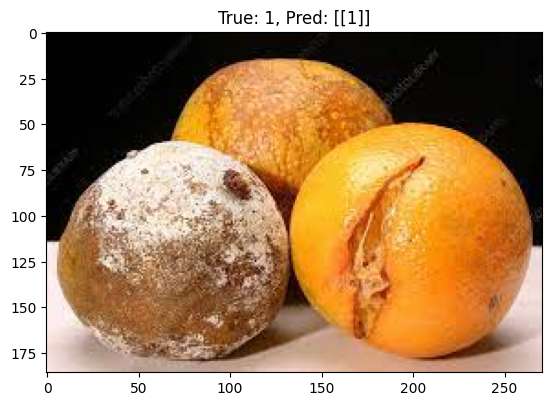

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


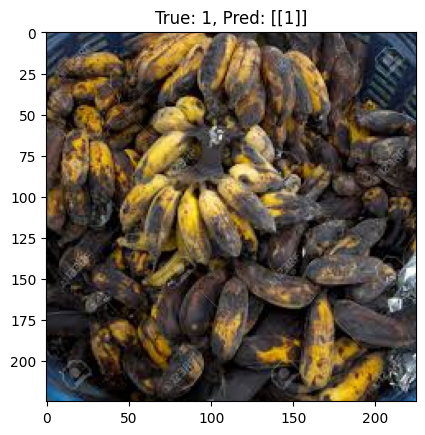

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


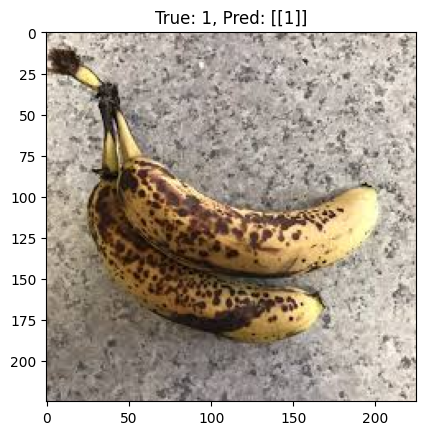

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


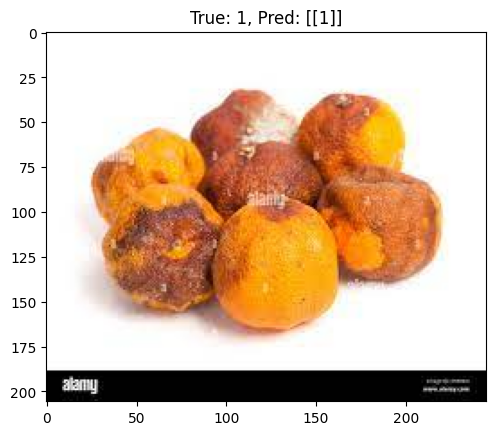

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


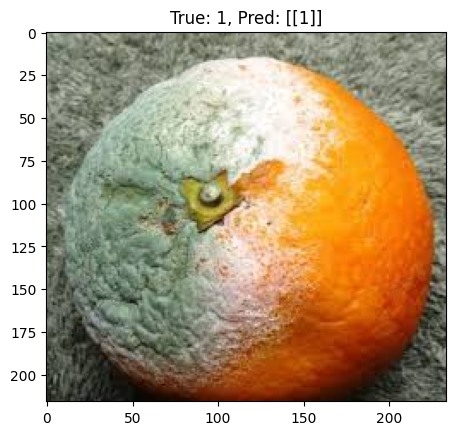

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


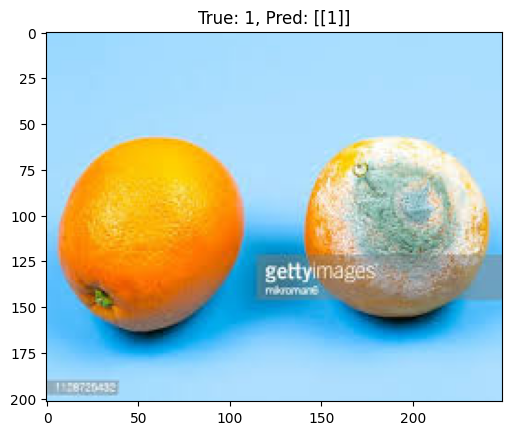

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


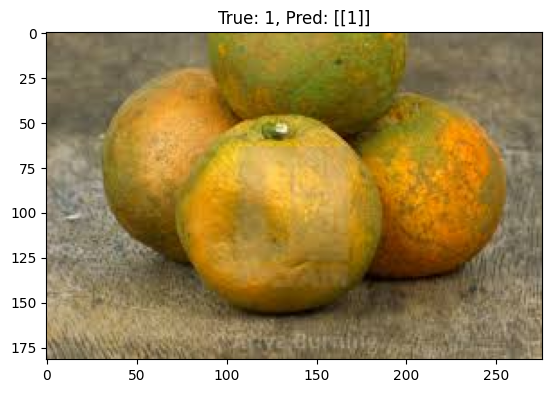

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


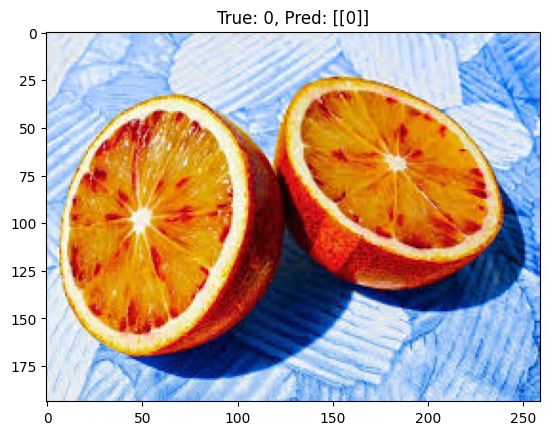

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


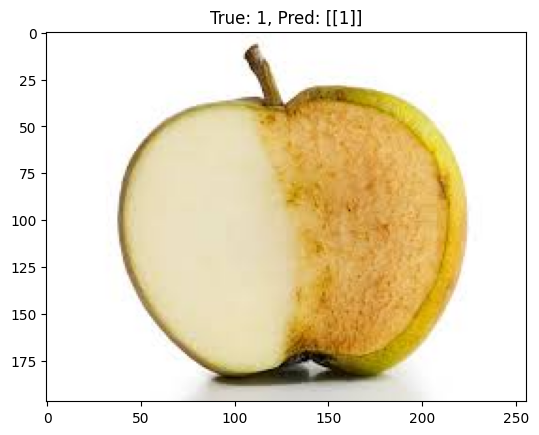

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


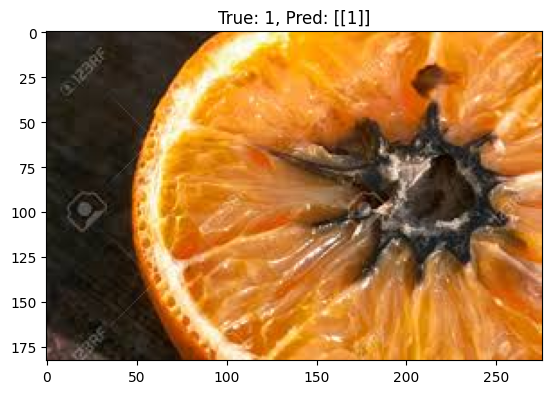

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


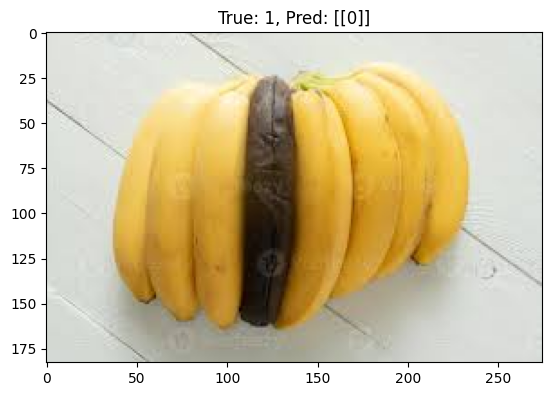

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


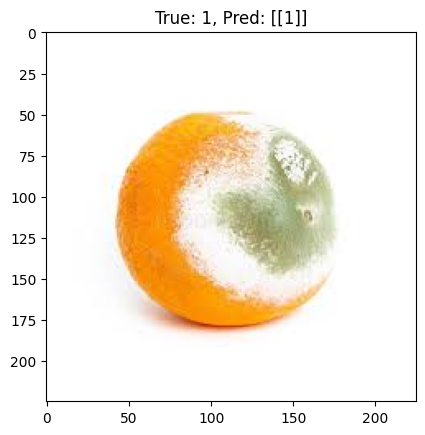

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


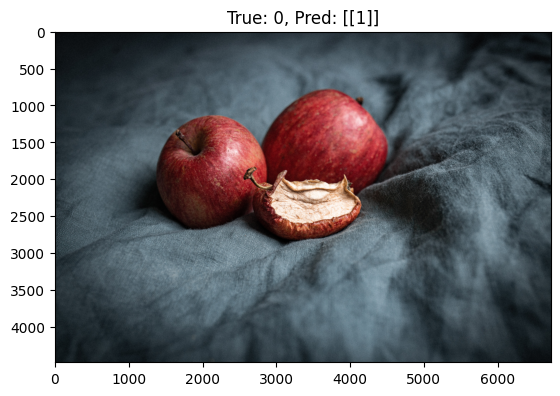

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


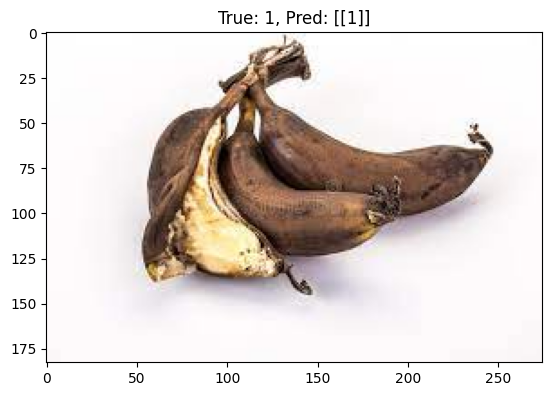

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


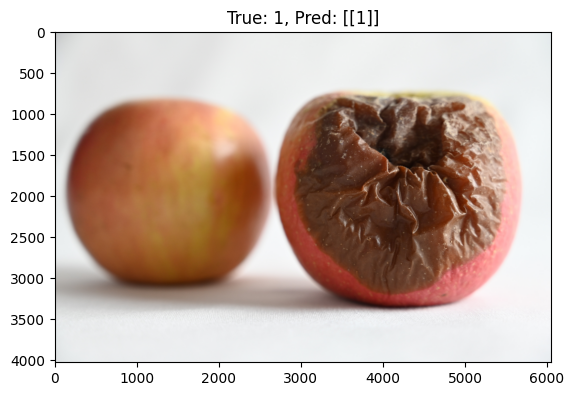

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


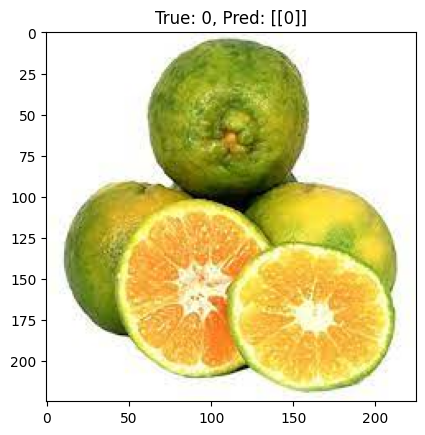

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


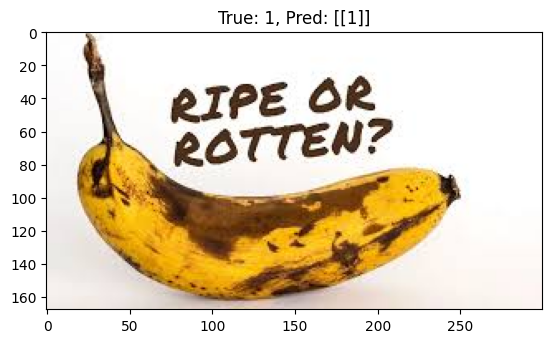

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


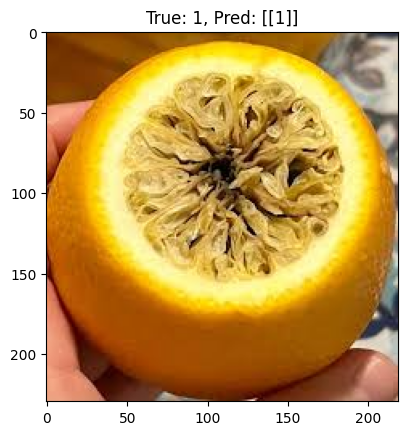

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


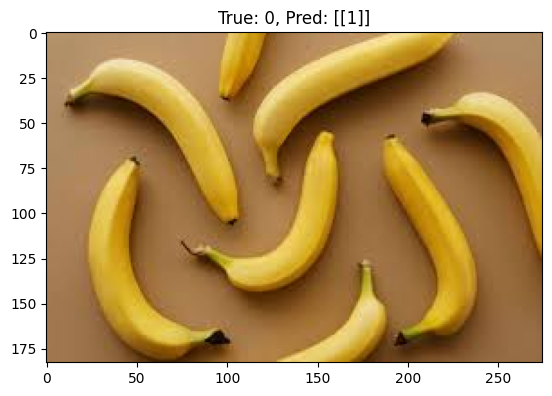

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


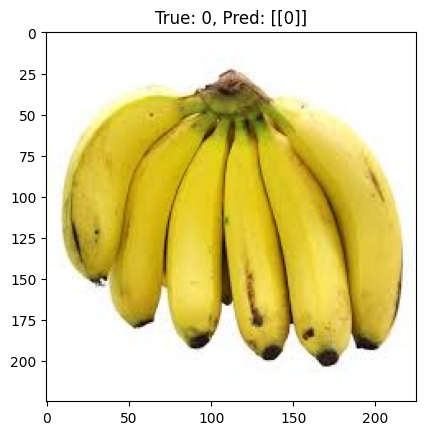

In [44]:
# Function - 
def test_random_image(df, model, num_of_images):
  # Nhan df, model va so luong hinh muon test
  # Lay random hinh
  random_images = df.sample(num_of_images)
  for index, row in random_images.iterrows():
    path = row['file_path']
    true_label = row['label']
    
    test_image = load_and_preprocess_image(path)

    prediction = model.predict(test_image)
    predicted_class = np.round(prediction).astype(int)

    image = load_img(path)

    plt.imshow(image)
    plt.title(f"True: {true_label}, Pred: {predicted_class}")
    plt.show()

test_random_image(test_df, model, 20)